In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
#ignore error if not found
!rmdir /s /q logs

The system cannot find the file specified.


In [2]:
import datetime
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
                                    Dense,
                                    Conv2D,
                                    MaxPool2D,
                                    BatchNormalization,
                                    Flatten,
                                    Dropout
                                    )

In [3]:
train_dir = "../dataset/train"
test_dir = "../dataset/test"

In [4]:
BATCH_SIZE = 64
IMG_SIZE = 224
EPOCHS = 15
lr = 0.00003
(b1, b2) = (0.999, 0.99)
CLASSES = ["mask", "no mask"]

In [62]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.1
)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE, subset='training')
val_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE, subset='validation')

Found 1184 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [63]:
test_generator = train_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE)

Found 194 images belonging to 2 classes.


In [75]:
def visualize_dataset(m=9):
    # Note: "n" must be a square number
    n = np.random.choice(len(train_generator))
    images = train_generator[n][0]
    labels = train_generator[n][1]
    a = int(m*(1/2))-1
    fig, axes = plt.subplots(a, a, figsize=(4, 4))
    for i in range(a):
        for j in range(a):
            axes[i, j].imshow((images[i+j]*255).astype('uint8'))
            axes[i, j].set_title(CLASSES[int(labels[i+j])])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

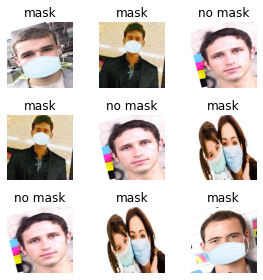

In [76]:
visualize_dataset()

In [66]:
vgg = tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3), pooling='avg')
for layer in vgg.layers:
    layer.trainable = False

In [67]:
model = Sequential([
    vgg,
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [68]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 65,793
Non-trainable params: 14,714,688
_________________________________________________________________


In [69]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc'])

In [70]:
#making log dirs and callback ready for tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#earlystopping callback for model to stop training if there is no change for some epochs
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#save model state with the best accuracy during training
checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoints/checkpoint_model.h5", monitor='loss', verbose=1, save_best_only=True, save_freq='epoch')


In [71]:
model.fit(train_generator, 
          steps_per_epoch=len(train_generator), 
          workers=4, 
          epochs=EPOCHS, 
          validation_data=val_generator,
          validation_steps=len(val_generator),
          callbacks=[tensorboard_callback, earlystop, checkpoint])

Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: 0.6293 - acc: 0.6486
Epoch 00001: loss improved from inf to 0.62933, saving model to checkpoints\checkpoint_model.h5
19/19 [==============================] - 13s 673ms/step - loss: 0.6293 - acc: 0.6486 - val_loss: 0.5171 - val_acc: 0.8308
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: 0.4798 - acc: 0.8345
Epoch 00002: loss improved from 0.62933 to 0.47975, saving model to checkpoints\checkpoint_model.h5
19/19 [==============================] - 10s 506ms/step - loss: 0.4798 - acc: 0.8345 - val_loss: 0.3722 - val_acc: 0.9615
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: 0.3584 - acc: 0.9172
Epoch 00003: loss improved from 0.47975 to 0.35843, saving model to checkpoints\checkpoint_model.h5
19/19 [==============================] - 10s 517ms/step - loss: 0.3584 - acc: 0.9172 - val_loss: 0.2779 - val_acc: 0.9538
Epoch 4/15
19/19 [==============================] - ETA: 0s - loss: 0.2

In [72]:
model.evaluate(test_generator)

4/4 [==============================] - 1s 320ms/step - loss: 0.0575 - acc: 0.9845


[0.05751015990972519, 0.9845361113548279]

In [56]:
#Save the model for using in face mask detection

# model.save("../models/mask_detection.h5")